Step: 0, Accuracy: 0.5
Step: 500, Accuracy: 0.5
Step: 1000, Accuracy: 0.5
Step: 1500, Accuracy: 0.5
Step: 2000, Accuracy: 0.5


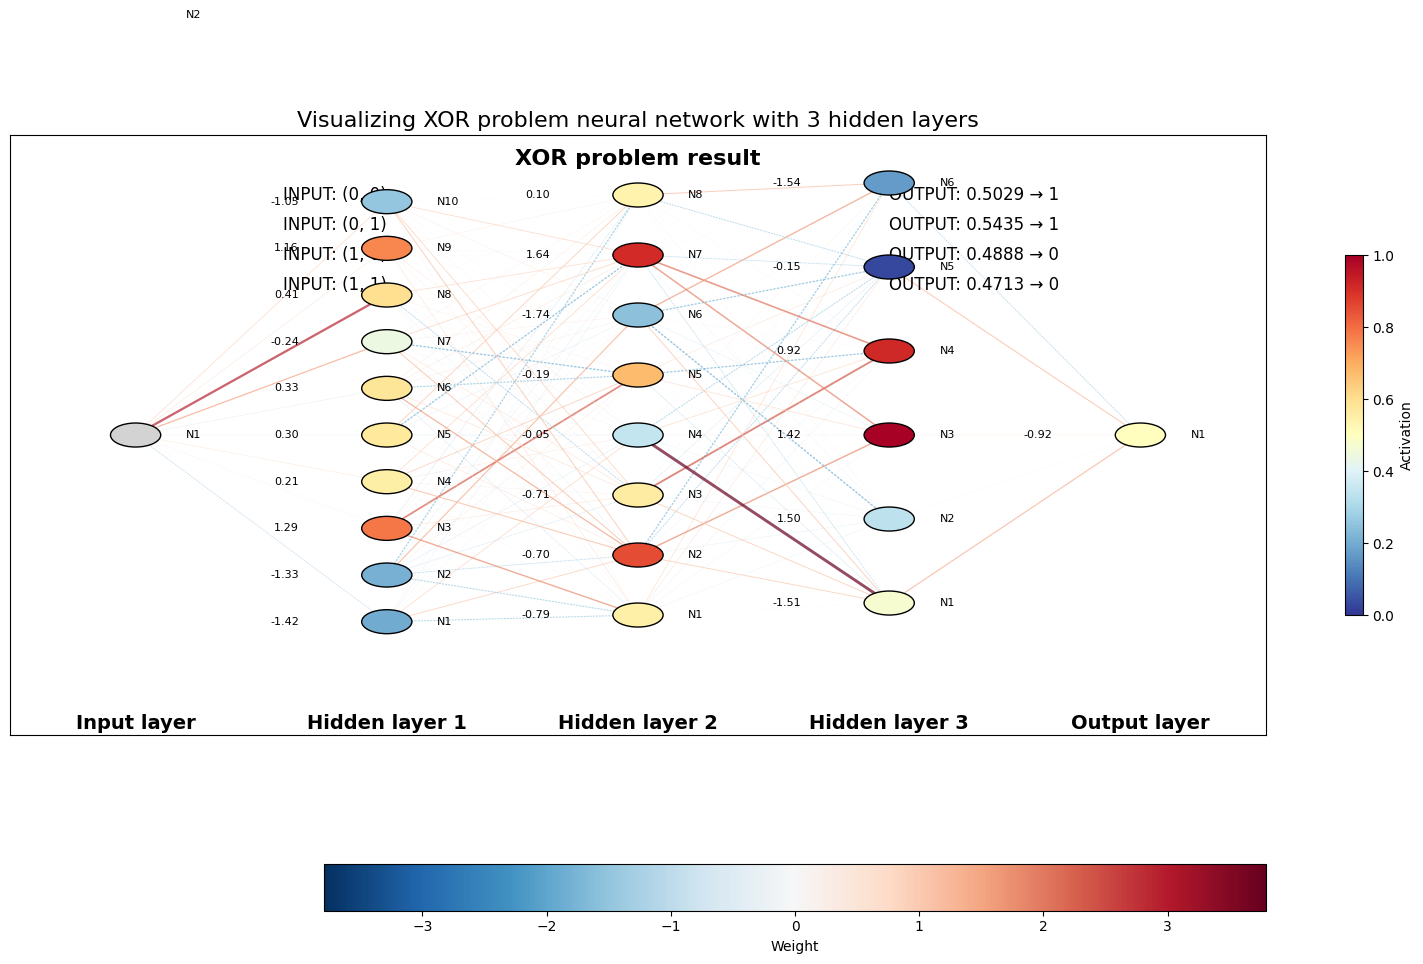

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, ConnectionPatch
import matplotlib.colors as mcolors

# XOR 문제 데이터 설정
x_data = np.array([[0,0],
              [0,1],
              [1,0],
              [1,1]], dtype=np.float32)
y_data = np.array([[0],[1],[1],[0]], dtype=np.float32)

# 은닉층 3개로 구성된 신경망 정의
# 레이어 구조: 입력(2) -> 은닉1(10) -> 은닉2(8) -> 은닉3(6) -> 출력(1)
W1 = tf.Variable(tf.random.normal([2, 10]))  # 첫 번째 은닉층 가중치
b1 = tf.Variable(tf.random.normal([10]))     # 첫 번째 은닉층 편향

W2 = tf.Variable(tf.random.normal([10, 8]))  # 두 번째 은닉층 가중치
b2 = tf.Variable(tf.random.normal([8]))      # 두 번째 은닉층 편향

W3 = tf.Variable(tf.random.normal([8, 6]))   # 세 번째 은닉층 가중치
b3 = tf.Variable(tf.random.normal([6]))      # 세 번째 은닉층 편향

W4 = tf.Variable(tf.random.normal([6, 1]))   # 출력층 가중치
b4 = tf.Variable(tf.random.normal([1]))      # 출력층 편향

learning_rate = 0.1

def forward_pass(x):
    """순방향 전파 연산"""
    layer1 = tf.sigmoid(tf.matmul(x, W1) + b1)
    layer2 = tf.sigmoid(tf.matmul(layer1, W2) + b2)
    layer3 = tf.sigmoid(tf.matmul(layer2, W3) + b3)
    output = tf.sigmoid(tf.matmul(layer3, W4) + b4)
    return layer1, layer2, layer3, output

def logisticRegression():
    """학습 함수"""
    with tf.GradientTape() as tape:
        layer1, layer2, layer3, hypothesis = forward_pass(x_data)
        cost = -tf.reduce_mean(y_data * tf.math.log(hypothesis) + (1 - y_data) * tf.math.log(1 - hypothesis))

        gradients = tape.gradient(cost, (W4, b4, W3, b3, W2, b2, W1, b1))
        tf.optimizers.SGD(learning_rate).apply_gradients(
            zip(gradients, (W4, b4, W3, b3, W2, b2, W1, b1)))

# 학습 수행
for step in range(2001):
    logisticRegression()

    if step % 500 == 0:
        layer1, layer2, layer3, hypothesis = forward_pass(x_data)
        prediction = tf.cast(hypothesis > 0.5, dtype=tf.float32)
        accuracy = tf.reduce_mean(tf.cast(tf.equal(prediction, y_data), dtype=np.float32))
        print(f"Step: {step}, Accuracy: {accuracy.numpy()}")

# 최종 결과 계산
final_layer1, final_layer2, final_layer3, final_output = forward_pass(x_data)

# 학습된 신경망 시각화 함수
def visualize_network(W1, b1, W2, b2, W3, b3, W4, b4, layer1, layer2, layer3, output):
    """신경망 구조와 가중치를 시각화"""
    fig = plt.figure(figsize=(16, 10))
    ax = fig.add_subplot(111)

    # 레이어 구성 정의
    layer_sizes = [2, 10, 8, 6, 1]  # 각 레이어의 뉴런 수
    layer_names = ['Input layer', 'Hidden layer 1', 'Hidden layer 2', 'Hidden layer 3', 'Output layer']

    # x 좌표 설정 (레이어 간 간격)
    layer_positions = [0.1, 0.3, 0.5, 0.7, 0.9]

    # 레이어별 y 간격 계산
    v_spacing = [0.7/(n-1) if n > 1 else 0.7 for n in layer_sizes]
    v_offset = [0.15 + v/2 for v in v_spacing]

    # 가중치와 바이어스 정규화를 위한 최대/최소값 계산
    all_weights = np.concatenate([W1.numpy().flatten(),
                                 W2.numpy().flatten(),
                                 W3.numpy().flatten(),
                                 W4.numpy().flatten()])
    max_weight = max(abs(np.max(all_weights)), abs(np.min(all_weights)))

    all_biases = np.concatenate([b1.numpy().flatten(),
                               b2.numpy().flatten(),
                               b3.numpy().flatten(),
                               b4.numpy().flatten()])
    max_bias = max(abs(np.max(all_biases)), abs(np.min(all_biases)))

    # 활성화 값 추출
    activations = [None, layer1.numpy(), layer2.numpy(), layer3.numpy(), output.numpy()]

    # 노드 위치 저장
    node_positions = []

    # 각 레이어 그리기
    for l, layer_size in enumerate(layer_sizes):
        # 현재 레이어의 노드 위치 저장
        layer_nodes = []

        # 레이어 제목 추가
        plt.text(layer_positions[l], 0.02, layer_names[l],
                ha='center', va='center', fontsize=14, fontweight='bold')

        # 각 레이어의 뉴런 그리기
        for i in range(layer_size):
            # 뉴런 위치 계산
            if layer_size == 1:
                y_pos = 0.5
            else:
                y_pos = v_offset[l] + i * v_spacing[l]

            # 노드 위치 저장
            layer_nodes.append((layer_positions[l], y_pos))

            # 뉴런 활성화 값에 따른 색상 설정
            if l > 0:  # 입력층 이외
                activation = activations[l][0, i] if l < len(layer_sizes)-1 else activations[l][0, 0]
                color = plt.cm.RdYlBu_r(activation)
            else:  # 입력층
                color = 'lightgray'

            # 뉴런 바이어스 표시 (입력층 제외)
            if l > 0:
                # 인덱스 오류 수정: 각 레이어에 맞는 바이어스 배열 사용
                bias_arrays = [b1.numpy(), b2.numpy(), b3.numpy(), b4.numpy()]
                curr_bias_array = bias_arrays[l-1]

                # 현재 뉴런의 바이어스 값 가져오기 (인덱스 범위 검사)
                if i < len(curr_bias_array):
                    bias_value = curr_bias_array[i]
                    bias_color = plt.cm.RdBu_r(0.5 + bias_value/(2*max_bias))

                    # 바이어스 값 표시
                    if layer_size <= 10:  # 너무 많은 뉴런이 있을 경우 바이어스 값은 표시하지 않음
                        plt.text(layer_positions[l]-0.07, y_pos, f'{bias_value:.2f}',
                                ha='right', va='center', fontsize=8)

                node = Circle((layer_positions[l], y_pos), 0.02,
                             color=color, ec='black', zorder=4)
                ax.add_patch(node)
            else:
                node = Circle((layer_positions[l], y_pos), 0.02,
                             color=color, ec='black', zorder=4)
                ax.add_patch(node)

            # 뉴런 번호 표시
            plt.text(layer_positions[l]+0.04, y_pos, f'N{i+1}',
                    ha='left', va='center', fontsize=8)

        node_positions.append(layer_nodes)

    # 가중치 행렬
    weights = [W1.numpy(), W2.numpy(), W3.numpy(), W4.numpy()]

    # 연결선 그리기
    for l in range(len(layer_sizes)-1):
        for i, source in enumerate(node_positions[l]):
            for j, target in enumerate(node_positions[l+1]):
                # 인덱스 범위 확인
                if i < weights[l].shape[0] and j < weights[l].shape[1]:
                    weight = weights[l][i, j]
                    # 가중치 정규화
                    normalized_weight = 0.5 + weight/(2*max_weight)
                    color = plt.cm.RdBu_r(normalized_weight)

                    # 가중치 절대값에 따른 선 두께 설정
                    linewidth = 0.1 + 2.0 * abs(weight)/max_weight

                    # 선 스타일 (양수는 실선, 음수는 점선)
                    linestyle = '-' if weight > 0 else ':'

                    # 연결선 그리기
                    con = ConnectionPatch(source, target, 'data', 'data',
                                        arrowstyle='-', shrinkA=5, shrinkB=5,
                                        linewidth=linewidth, linestyle=linestyle,
                                        color=color, alpha=0.7, zorder=2)
                    ax.add_artist(con)

    # 레이어별 입출력 예시
    example_inputs = [[0, 0], [0, 1], [1, 0], [1, 1]]
    example_outputs = output.numpy()

    # XOR 입출력 예시 표시
    plt.text(0.5, 0.95, 'XOR problem result', ha='center', fontsize=16, fontweight='bold')
    for i, (inp, outp) in enumerate(zip(example_inputs, example_outputs)):
        y_pos = 0.9 - i*0.05
        plt.text(0.3, y_pos, f'INPUT: ({inp[0]}, {inp[1]})', ha='right', va='center', fontsize=12)
        plt.text(0.7, y_pos, f'OUTPUT: {outp[0]:.4f} → {1 if outp[0]>0.5 else 0}',
                ha='left', va='center', fontsize=12)

    # 컬러바 추가
    cmap_weight = plt.cm.ScalarMappable(cmap=plt.cm.RdBu_r)
    cmap_weight.set_clim(-max_weight, max_weight)
    cbar_weight = plt.colorbar(cmap_weight, ax=ax, location='bottom', shrink=0.6)
    cbar_weight.set_label('Weight')

    cmap_act = plt.cm.ScalarMappable(cmap=plt.cm.RdYlBu_r)
    cmap_act.set_clim(0, 1)
    cbar_act = plt.colorbar(cmap_act, ax=ax, location='right', shrink=0.6)
    cbar_act.set_label('Activation')

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('Visualizing XOR problem neural network with 3 hidden layers', fontsize=16)
    plt.tight_layout()
    plt.show()

# 시각화 실행
visualize_network(W1, b1, W2, b2, W3, b3, W4, b4,
                 final_layer1, final_layer2, final_layer3, final_output)